<a href="https://colab.research.google.com/github/jmbaek/ImageCNN/blob/main/plantDisease_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
!git clone https://github.com/mehra-deepak/Plant-Disease-Detection.git

Cloning into 'Plant-Disease-Detection'...
remote: Enumerating objects: 20439, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 20439 (delta 34), reused 76 (delta 30), pack-reused 20355
Receiving objects: 100% (20439/20439), 181.04 MiB | 36.67 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [94]:
!mv Plant-Disease-Detection/image_classification/dataset/ dataset/
!mv Plant-Disease-Detection/image_classification/output/ output/

In [95]:
!pip install mahotas
!pip install joblib

     |████████████████████████████████| 5.7 MB 6.9 MB/s 


In [96]:
#-----------------------------------
# GLOBAL FEATURE EXTRACTION
#-----------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

#--------------------
# tunable-parameters
#--------------------
images_per_class       = 800
fixed_size             = tuple((500, 500))
train_path             = "dataset/train"
h5_train_data          = 'output/train_data.h5'
h5_train_labels        = 'output/train_labels.h5'
bins                   = 8

In [97]:
# Converting each image to RGB from BGR format

def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img

# Conversion to HSV image format from RGB

def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

# image segmentation

# for extraction of green and brown color


def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result

# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()



In [98]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['diseased', 'healthy']


In [ ]:
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" + str(x) + ".jpg"

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        
        # Running Function Bit By Bit
        
        RGB_BGR       = rgb_bgr(image)
        BGR_HSV       = bgr_hsv(RGB_BGR)
        IMG_SEGMENT   = img_segmentation(RGB_BGR,BGR_HSV)

        # Call for Global Fetaure Descriptors
        
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick   = fd_haralick(IMG_SEGMENT)
        fv_histogram  = fd_histogram(IMG_SEGMENT)
        
        # Concatenate 
        
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
        

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" + str(x) + ".jpg"

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        
        # Running Function Bit By Bit
        
        RGB_BGR       = rgb_bgr(image)
        BGR_HSV       = bgr_hsv(RGB_BGR)
        IMG_SEGMENT   = img_segmentation(RGB_BGR,BGR_HSV)

        # Call for Global Fetaure Descriptors
        
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick   = fd_haralick(IMG_SEGMENT)
        fv_histogram  = fd_histogram(IMG_SEGMENT)
        
        # Concatenate 
        
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
        
        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: diseased
[STATUS] processed folder: healthy
[STATUS] completed Global Feature Extraction...
[STATUS] processed folder: diseased


In [ ]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

[STATUS] feature vector size (3200, 532)


In [ ]:
# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

[STATUS] training Labels (3200,)


In [ ]:
# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

[STATUS] training labels encoded...


In [ ]:
# scale features in the range (0-1)
from sklearn.preprocessing import MinMaxScaler
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

[STATUS] feature vector normalized...


In [ ]:
print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] target labels: [0 0 0 ... 1 1 1]
[STATUS] target labels shape: (3200,)


In [ ]:
# save the feature vector using HDF5
h5f_data = h5py.File(h5_train_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

<HDF5 dataset "dataset_1": shape (3200, 532), type "<f8">

In [ ]:
h5f_label = h5py.File(h5_train_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

<HDF5 dataset "dataset_1": shape (3200,), type "<i8">

In [ ]:
h5f_data.close()
h5f_label.close()

In [ ]:
# training
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import joblib

warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.20
seed      = 9
train_path = "dataset/train"
test_path  = "dataset/test"
h5_train_data    = 'output/train_data.h5'
h5_train_labels  = 'output/train_labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_train_data, 'r')
h5f_label = h5py.File(h5_train_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (3200, 532)
[STATUS] labels shape: (3200,)
[STATUS] training started...


In [ ]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape)) 


[STATUS] splitted train and test data...
Train data  : (2560, 532)
Test data   : (640, 532)


In [ ]:
trainDataGlobal

array([[0.94841559, 0.03634138, 0.        , ..., 0.01058888, 0.12693561,
        0.96573219],
       [0.99116547, 0.04421731, 0.15910779, ..., 0.01067093, 0.13053338,
        0.96571272],
       [0.9888642 , 0.00192622, 0.00155258, ..., 0.01101657, 0.12930965,
        0.96523171],
       ...,
       [0.80833075, 0.03775402, 0.00276642, ..., 0.01058889, 0.1269317 ,
        0.96573212],
       [0.96965597, 0.        , 0.        , ..., 0.01058989, 0.1271198 ,
        0.96574232],
       [0.98389776, 0.19183335, 0.15462199, ..., 0.01058898, 0.12695993,
        0.96573136]])

LR: 0.933984 (0.015669)
LDA: 0.931250 (0.013777)
KNN: 0.945703 (0.017768)
CART: 0.975781 (0.008341)
RF: 0.987891 (0.009318)
NB: 0.860547 (0.018243)
SVM: 0.934766 (0.012961)


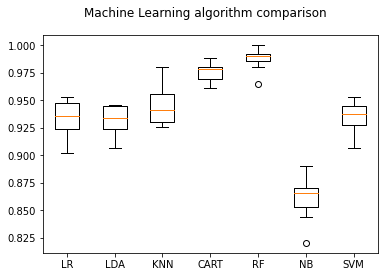

In [ ]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [ ]:
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)
clf.fit(trainDataGlobal, trainLabelsGlobal)

RandomForestClassifier(random_state=9)

In [ ]:
y_predict=clf.predict(testDataGlobal)
y_predict


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,

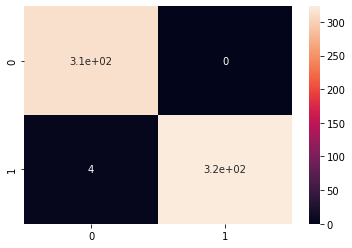

In [ ]:
cm = confusion_matrix(testLabelsGlobal,y_predict)
import seaborn as sns
sns.heatmap(cm ,annot=True)


In [ ]:


print(classification_report(testLabelsGlobal,y_predict))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       313
           1       1.00      0.99      0.99       327

    accuracy                           0.99       640
   macro avg       0.99      0.99      0.99       640
weighted avg       0.99      0.99      0.99       640



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(testLabelsGlobal, y_predict)



0.99375

## CNN Learning


In [3]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset.git

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 26.32 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (182401/182401), done.


In [5]:
!mkdir data
!mv PlantVillage-Dataset/data_distribution_for_SVM/test/ data/test/
!mv PlantVillage-Dataset/data_distribution_for_SVM/train/ data/train/

In [52]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [53]:
epochs = 30
batch_size = 150
testsplit = .2
targetx = 224
targety = 224
learning_rate = 0.0001
classes = 38
seed = random.randint(1, 1000)

data_dir = "data/train/"
data_dir1 = "data/test/"

In [54]:
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)

test_generator = datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation"
)

Found 7017 images belonging to 38 classes.
Found 2094 images belonging to 38 classes.


data/train/21/4e6f9765-1317-4c67-a7c1-e1f1614f7b23.JPG


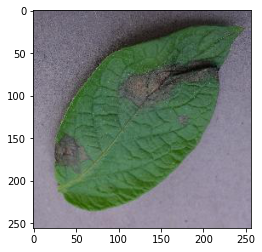

In [88]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [56]:
checkpoint = ModelCheckpoint('dog_breed_classifier.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

In [92]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()
#for i, layer in enumerate(model.layers):
#    print(i, layer.name, layer.trainable)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [59]:
%%time
history = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=test_generator, 
                                validation_steps=len(test_generator),
                                epochs=epochs,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])

Learning rate:  1e-04
Epoch 1/30
47/47 [==============================] - ETA: 0s - loss: 1.3088 - accuracy: 0.6664
Epoch 1: val_accuracy improved from -inf to 0.47326, saving model to dog_breed_classifier.h5
47/47 [==============================] - 132s 2s/step - loss: 1.3088 - accuracy: 0.6664 - val_loss: 2.2515 - val_accuracy: 0.4733 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 2/30
47/47 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9387
Epoch 2: val_accuracy improved from 0.47326 to 0.51194, saving model to dog_breed_classifier.h5
47/47 [==============================] - 110s 2s/step - loss: 0.2351 - accuracy: 0.9387 - val_loss: 1.8871 - val_accuracy: 0.5119 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 3/30
47/47 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9721
Epoch 3: val_accuracy improved from 0.51194 to 0.56734, saving model to dog_breed_classifier.h5
47/47 [==============================] - 107s 2s/step - loss: 0.1154 - ac

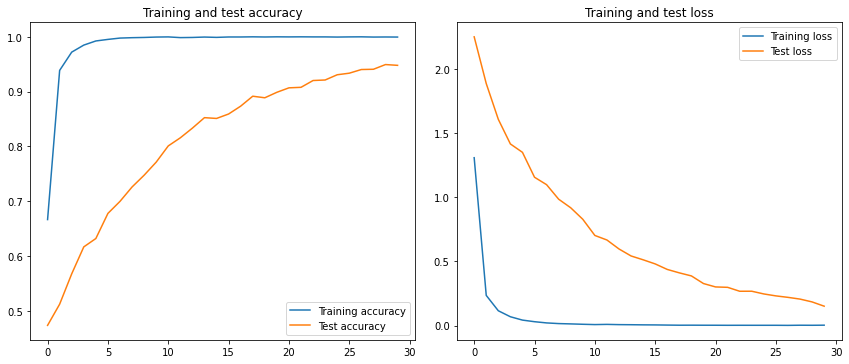

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(12,5))
fig.tight_layout()
plt.subplot(1, 2, 1)
plt.title('Training and test accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Test accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and test loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Test loss')
plt.legend()

plt.show()

In [63]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.93        22
           1       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        44
          11       0.88      1.00      0.94        44
          12       1.00      0.87      0.93        46
          13       0.98      1.00      0.99        44
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00       233
          16       1.00      0.97      0.98        88
          17       0.80      1.00      0.89         4
          18       0.95      0.84      0.89        25
          19       0.95      0.97      0.96        60
           2       1.00      0.92      0.96        12
          20       1.00      0.95      0.98        44
          21       0.89      0.82      0.86        40
          22       0.20      0.33      0.25         3
          23       1.00      1.00      1.00        36
     

Confusion Matrix


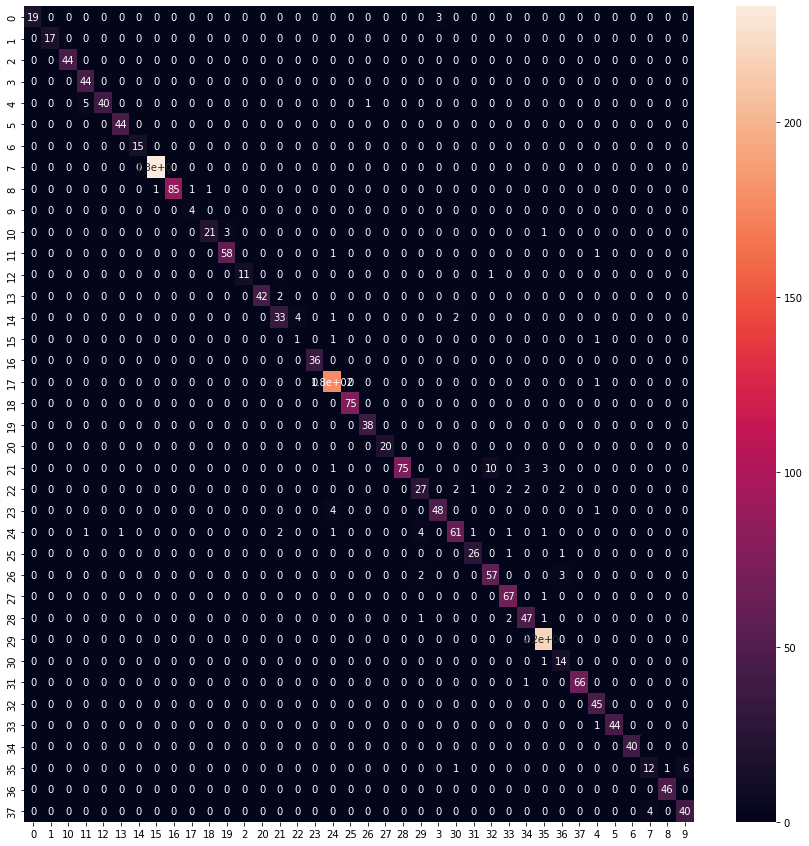

In [75]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y)
df = pd.DataFrame(cm, columns=test_generator.class_indices)
plt.figure(figsize=(15,15))
sn.heatmap(df, annot=True)

In [35]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir) 
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

38 Classes
8751 Train images
10547 Test images


In [10]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.2,
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [36]:
img_width,img_height =256,256
input_shape=(img_width,img_height,3)
batch_size =32
train_generator =train_datagen.flow_from_directory(train_dir,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)

Found 8751 images belonging to 38 classes.
Found 10547 images belonging to 38 classes.


In [51]:

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
#resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
resnet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in resnet.layers[:-4]:
    layer.trainable = False

def nvidia_model():
  model = Sequential()
  model.add(resnet)

  model.add(Dropout(0.5))

  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(38))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

model = nvidia_model()
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
Total params: 2,257,984
Trainable params: 412,800
Non-trainable params: 1,845,184
_________________________________________________________________


In [45]:
model_layers = [ layer.name for layer in model.layers]
print('layer name : ',model_layers)

layer name :  ['resnet50', 'dropout_36', 'flatten_9', 'dense_36', 'dropout_37', 'dense_37', 'dropout_38', 'dense_38', 'dropout_39', 'dense_39']


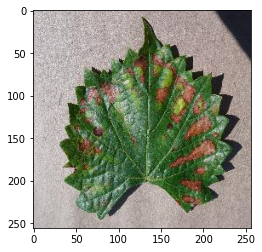

In [46]:
from tensorflow.keras.preprocessing import image
import numpy as np
img1 = image.load_img('data/train/12/049c8615-7d94-4a4b-8467-fe20c0cecac1.JPG')
plt.imshow(img1);
img1 = image.load_img('data/test/13/00d8329b-6621-4e08-8ec5-cf702eb3b205.JPG', target_size=(256, 256))
img = image.img_to_array(img1)
img = img/255
img = np.expand_dims(img, axis=0)

In [47]:
from tensorflow.keras.models import Model
conv2d_1_output = Model(inputs=model.input, outputs=model.get_layer('conv2d_7').output)
max_pooling2d_1_output = Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_7').output)
conv2d_2_output = Model(inputs=model.input,outputs=model.get_layer('conv2d_8').output)
max_pooling2d_2_output = Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_8').output)
conv2d_3_output = Model(inputs=model.input,outputs=model.get_layer('conv2d_9').output)
max_pooling2d_3_output = Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_9').output)
flatten_1_output = Model(inputs=model.input,outputs=model.get_layer('flatten_3').output)
conv2d_1_features = conv2d_1_output.predict(img)
max_pooling2d_1_features = max_pooling2d_1_output.predict(img)
conv2d_2_features = conv2d_2_output.predict(img)
max_pooling2d_2_features = max_pooling2d_2_output.predict(img)
conv2d_3_features = conv2d_3_output.predict(img)
max_pooling2d_3_features = max_pooling2d_3_output.predict(img)
flatten_1_features = flatten_1_output.predict(img)

ValueError: ignored

NameError: ignored

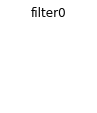

In [48]:
import matplotlib.image as mpimg
fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_1_features[0, :, :, i], cmap='viridis')
plt.show()

In [ ]:
import matplotlib.image as mpimg
fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(max_pooling2d_1_features[0, :, :, i], cmap='viridis')
plt.show()

In [ ]:
import matplotlib.image as mpimg
fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_2_features[0, :, :, i], cmap='viridis')
plt.show()

In [ ]:
import matplotlib.image as mpimg
fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(max_pooling2d_2_features[0, :, :, i], cmap='viridis')
plt.show()



In [ ]:
import matplotlib.image as mpimg
fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_3_features[0, :, :, i], cmap='viridis')
plt.show()

In [ ]:
import matplotlib.image as mpimg
fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(max_pooling2d_3_features[0, :, :, i], cmap='viridis')
plt.show()

In [ ]:
validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(img_height, img_width),
    batch_size=batch_size)

In [ ]:
opt=keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
train=model.fit_generator(train_generator,
                          nb_epoch=30,
                          steps_per_epoch=train_generator.samples // batch_size,
                          validation_data=validation_generator,
                          nb_val_samples= validation_generator.samples// batch_size,verbose=1)

In [ ]:
acc = train.history['acc']
val_acc = train.history['val_acc']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()